In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.time import Time, TimeDelta
import lsst.sims.downtimeModel as dt

In [2]:
tstart = Time('2022-01-01', format='isot', scale='tai')
day_offset = TimeDelta(-0.34, format='jd')

In [3]:
scheduledDowntimeData = dt.ScheduledDowntimeData(tstart, start_of_night_offset=day_offset)
scheduledDowntimeData.read_data()

In [61]:
print(len(scheduledDowntimeData.downtime))
print("First downtime", "start", scheduledDowntimeData.downtime[0]['start'].isot, 
      "end", scheduledDowntimeData.downtime[0]['end'].isot)
print("Last downtime", "start", scheduledDowntimeData.downtime[-1]['start'].isot, 
      "end", scheduledDowntimeData.downtime[-1]['end'].isot)

31
First downtime start 2022-06-07T15:50:24.000 end 2022-06-14T15:50:24.000
Last downtime start 2041-10-29T15:50:24.000 end 2041-11-05T15:50:24.000


In [5]:
unscheduledDowntimeData = dt.UnscheduledDowntimeData(tstart, start_of_night_offset=day_offset,
                                                    survey_length=3650*2, seed=3)
unscheduledDowntimeData.make_data()

In [6]:
print(len(unscheduledDowntimeData.downtime))
print(unscheduledDowntimeData.downtime[0])

145
(<Time object: scale='tai' format='isot' value=2022-03-01T15:50:24.000>, <Time object: scale='tai' format='isot' value=2022-03-02T15:50:24.000>, 'minor event')


In [7]:
dtModel = dt.DowntimeModel()

In [8]:
dtModel.config_info()

OrderedDict([('DowntimeModel_version', 'unknown'),
             ('DowntimeModel_sha',
              '10610aff95d2f5972de94dafb0175be63342ea0d *'),
             ('efd_columns', ['scheduled_downtimes', 'unscheduled_downtimes']),
             ('efd_delta_time', 0.0),
             ('target_columns', ['time'])])

In [9]:
# The EFD data for the downtime models is a little different than some of the other *Data values.
# Basically, you don't repeatedly query it (although that may make sense in production),
# and then you just pass the entire downtime arrays into the model.
sched_downtime = scheduledDowntimeData()
unsched_downtime = unscheduledDowntimeData()
efdData = {'scheduled_downtimes': sched_downtime,
           'unscheduled_downtimes': unsched_downtime}

In [10]:
# However, the target dict takes the current (or desired) time as its 'target'.
targetDict = {'time': tstart}

In [11]:
# And then the downtime model tells you:
# State of the system (True = system is down)
# End of current downtime
# Next expected (scheduled) downtime.
#  .. so the model provides some 'blindness' to the unscheduled downtime.

modelData = dtModel(efdData, targetDict)

In [12]:
modelData

{'status': False,
 'end': None,
 'next': <Time object: scale='tai' format='isot' value=2022-06-07T15:50:24.000>}

In [13]:
# Fast forward to a time that we know is in a downtime period..
targetDict = {'time': scheduledDowntimeData.downtime[0]['start']}
modelData = dtModel(efdData, targetDict)
modelData

{'status': True,
 'end': <Time object: scale='tai' format='isot' value=2022-06-14T15:50:24.000>,
 'next': <Time object: scale='tai' format='isot' value=2022-11-03T15:50:24.000>}

In [62]:
# And let's check in on the number of downtime nights and what they look like.
# Remember that defaults cover 20 years so we must cut down to the downtime within 10 years for 'defaults'.

In [108]:
unschedT = unscheduledDowntimeData.downtime[0:73]
unschedT[0], unschedT[-1]

((<Time object: scale='tai' format='isot' value=2022-03-01T15:50:24.000>, <Time object: scale='tai' format='isot' value=2022-03-02T15:50:24.000>, 'minor event'),
 (<Time object: scale='tai' format='isot' value=2032-08-27T15:50:24.000>, <Time object: scale='tai' format='isot' value=2032-08-28T15:50:24.000>, 'minor event'))

In [127]:
schedT = scheduledDowntimeData.downtime[0:17]
schedT[0], schedT[-1]
g = lambda x : print(x['start'].datetime.date(), x['end'].datetime.date(), (x['end'] - x['start']).jd)
for dt in schedT:
    g(dt)

2022-06-07 2022-06-14 7.0
2022-11-03 2022-11-10 7.0
2023-06-07 2023-06-14 7.0
2023-11-03 2023-11-10 7.0
2024-06-06 2024-06-20 14.0
2025-06-06 2025-06-13 7.0
2025-11-02 2025-11-09 7.0
2026-06-06 2026-06-20 14.0
2027-06-06 2027-06-13 7.0
2027-11-02 2027-11-09 7.0
2028-06-05 2028-06-19 14.0
2029-06-05 2029-06-12 7.0
2029-11-01 2029-11-08 7.0
2030-06-05 2030-06-19 14.0
2031-06-05 2031-06-12 7.0
2031-11-01 2031-11-08 7.0
2032-06-04 2032-06-18 14.0


Text(0, 0.5, 'Number of unscheduled downtime intervals')

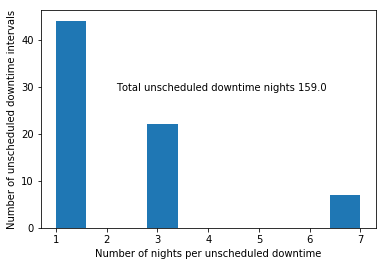

In [109]:
g = lambda x: (x['end'] - x['start']).jd
dts = []
for dt in unschedT:
    dts.append((g(dt)))

n, b, p = plt.hist(dts)
plt.figtext(.3, .6, f'Total unscheduled downtime nights {sum(dts)}')
plt.xlabel("Number of nights per unscheduled downtime")
plt.ylabel("Number of unscheduled downtime intervals")

Text(0, 0.5, 'Number of scheduled downtime intervals')

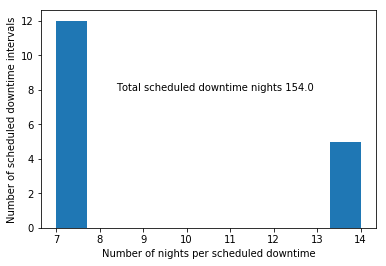

In [110]:
g = lambda x: (x['end'] - x['start']).jd
dts = []
for dt in schedT:
    dts.append((g(dt)))
n, b, p = plt.hist(dts)
plt.figtext(.3, .6, f'Total scheduled downtime nights {sum(dts)}')
plt.xlabel("Number of nights per scheduled downtime")
plt.ylabel("Number of scheduled downtime intervals")

(0, 4006.460000000149)

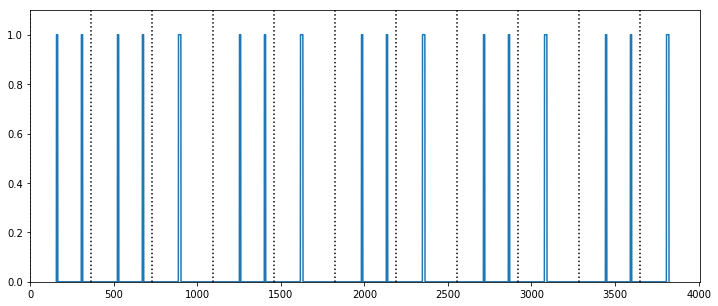

In [136]:
val = []
dts = []
for dt in schedT:
    val.append(0)
    dts.append(dt['start'].jd - 1)
    val.append(1)
    dts.append(dt['start'].jd)
    val.append(1)
    dts.append(dt['end'].jd)
    val.append(0)
    dts.append(dt['end'].jd + 1)
dts = np.array(dts)
dts = dts - 2459580
x = np.arange(0, 3652, 365)
plt.figure(figsize=(12, 5))
plt.plot(dts, val)
for yr in x:
    plt.axvline(yr, color='k', linestyle=':')
plt.ylim(0, 1.1)
plt.xlim(left=0)